In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import utility
from utils.encoder import OneHotEncoder, ThermometerEncoder, IntegerEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer, StandardScaler
import folktables
from folktables import ACSDataSource
from sklearn.metrics import classification_report
%load_ext autoreload
%autoreload 2

In [2]:
ACSIncomeNew = folktables.BasicProblem(
    features=[
        'COW',
        'AGEP', #age
        'SCHL', #education level
        'MAR',
        'OCCP',
        'POBP',
        'WKHP', #working per hours (0<=x<=99)
        'SEX',
        'RAC1P',
        'ENG', #english level
    ],
    target='PINCP', #total person's income
    target_transform=lambda x: x > 50000,
    group=['AGEP','SCHL','WKHP','ENG'],
    preprocess=folktables.adult_filter,
    postprocess=lambda x:x,
)

In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)

In [4]:
data, target, ordinal = ACSIncomeNew.df_to_pandas(ca_data)

In [5]:
if data.isnull().values.any():
    data = data.dropna()
    ordinal = ordinal.loc[data.index,:]
    target = target.loc[data.index,:]

In [6]:
nominal_features = ['COW', 'MAR', 'SEX', 'RAC1P']
ordinal_features = ['AGEP', 'SCHL', 'WKHP', 'ENG'] #ordinal.columns
label = ['PINCP'] #target.columns
other_features = list(set(data.columns) - (set(nominal_features + ordinal_features)))

ordinal_features_plus = ordinal_features[:2]

In [7]:
other_features

['OCCP', 'POBP']

In [8]:
unique_dic = utility.df_to_dict(data)
label_unique_dic = utility.df_to_dict(target)
unique_ordered_dic = utility.order(unique_dic, *(nominal_features+ordinal_features))

nominal_dic = {k: unique_ordered_dic[k] for k in set(unique_ordered_dic).intersection(nominal_features)}
ordinal_dic = {k: unique_ordered_dic[k] for k in set(unique_ordered_dic).intersection(ordinal_features)}
label_dic = {k: label_unique_dic[k] for k in label}

ordinal_dic_plus = {key: ordinal_dic[key] for key in ordinal_features_plus}

In [9]:
label_dic

{'PINCP': array([False,  True])}

In [10]:
step_sizes = {'AGEP': (0, 99, 10), 'WKHP': (1, 99, 10)}

In [11]:
ordinal_dic_intv = ordinal_dic.copy()
for key, val in step_sizes.items():
    ordinal_dic_intv[key] = np.arange(*val)
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic_intv.values()])
other_num + nom_num + ord_num, other_num + nom_num + len(ordinal_dic)

(74, 30)

In [12]:
df=pd.concat([data, target],axis=1)
df.to_csv('clean_dataset/acs_datasource_clf/acs_datasource_clf.csv', index=False)
feature_dic = {'nominal': nominal_dic, 'ordinal': ordinal_dic_intv, 'label': label_dic, 'step_sizes': step_sizes}
import pickle
with open('clean_dataset/acs_datasource_clf/acs_datasource_clf_dic.pkl', 'wb') as f:
    pickle.dump(feature_dic, f)

Text(0.5, 1.0, "Adult's Income")

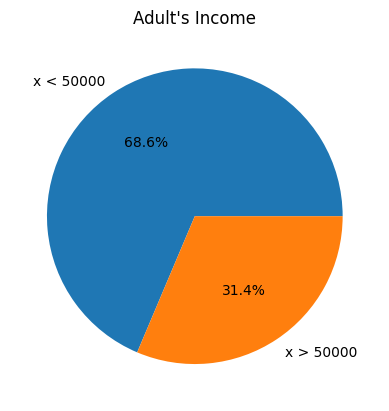

In [13]:
labels = list(label_dic.values())[0]

sizes = [len(target[target['PINCP'] == val]) for val in labels]
plt.pie(sizes, labels=['x > 50000' if val else 'x < 50000' for val in labels], autopct='%1.1f%%')
plt.title("Adult's Income")

In [14]:
# import random
# from sklearn.model_selection import KFold
# k=10
# regr = LogisticRegression(max_iter=1000)
# test_pred_res, test_true_res = [], []
# train_pred_res, train_true_res = [], []
# df = pd.concat([data, target],axis=1)
# sc = StandardScaler()
# kf = KFold(k)   
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]
# for train_index, test_index in kf.split(df):
#     X_train, y_train, X_test, y_test = X.iloc[train_index], pd.DataFrame(y.iloc[train_index]), X.iloc[test_index], pd.DataFrame(y.iloc[test_index])
#     # random_train, random_test, _ = utility.encoding_pipeline(X_train[ordinal_features_plus], X_test[ordinal_features_plus], ThermometerEncoder, ordinal_dic_plus)
#     nominal_train, nominal_test, _ = utility.encoding_pipeline(X_train[nominal_features], X_test[nominal_features], OneHotEncoder, nominal_dic)
#     ordinal_train, ordinal_test, _ = utility.encoding_pipeline(X_train[ordinal_features], X_test[ordinal_features], IntegerEncoder, ordinal_dic, step_sizes=step_sizes)
#     other_train, other_test = np.array(X_train[other_features].values), np.array(X_test[other_features].values)
#     sc.fit(other_train)
#     other_train, other_test = sc.transform(other_train), sc.transform(other_test)
#     y_train, y_test, _ = utility.encoding_pipeline(y_train, y_test, IntegerEncoder, label_dic)
#     # X_train_all, X_test_all = ordinal_train, ordinal_test
#     # X_train_all, X_test_all = np.concatenate([ordinal_train], axis=1), np.concatenate([ordinal_test], axis=1)
#     X_train_all, X_test_all = np.concatenate([other_train, nominal_train, ordinal_train], axis=1), np.concatenate([other_test, nominal_test, ordinal_test], axis=1)
#     regr.fit(X_train_all, y_train)
#     y_pred_test = regr.predict(X_test_all)
#     y_pred_train = regr.predict(X_train_all)
#     test_true_res = test_true_res+ [np.squeeze(y_test)] if len(test_true_res)> 0 else [np.squeeze(y_test)]
#     test_pred_res = test_pred_res+ [np.squeeze(y_pred_test)] if len(test_pred_res)> 0 else [np.squeeze(y_pred_test)]
#     train_true_res = train_true_res+ [np.squeeze(y_train)] if len(train_true_res)> 0 else [np.squeeze(y_train)]
#     train_pred_res = train_pred_res+ [np.squeeze(y_pred_train)] if len(train_pred_res)> 0 else [np.squeeze(y_pred_train)]

# test_temp_res, train_temp_res = [], []
# for i in range(k):
#     test_temp_res.append(classification_report(test_true_res[i], test_pred_res[i], output_dict=True)) 
#     train_temp_res.append(classification_report(train_true_res[i], train_pred_res[i], output_dict=True)) 
# clf_rep_dic_test, clf_rep_dic_train = utility.concat_dic(*test_temp_res), utility.concat_dic(*train_temp_res)
# test_res, train_res = utility.mean_std_dic(clf_rep_dic_test), utility.mean_std_dic(clf_rep_dic_train)

In [15]:
# train_res['accuracy'], test_res['accuracy']

In [16]:
# import random
# from sklearn.model_selection import KFold
# df = pd.concat([data, target],axis=1)
# k=10
# test_size = 0.25
# regr = Ridge()
# test_pred_res, test_true_res = [], []
# train_pred_res, train_true_res = [], []
# sc = StandardScaler()
# kf = KFold(k)   
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]
# random.seed(0)
# for train_index, test_index in kf.split(df):
#     X_train, y_train, X_test, y_test = X.iloc[train_index], pd.DataFrame(y.iloc[train_index]), X.iloc[test_index], pd.DataFrame(y.iloc[test_index])
#     # random_train, random_test, _ = utility.encoding_pipeline(X_train[ordinal_features_plus], X_test[ordinal_features_plus], ThermometerEncoder, ordinal_dic_plus)
#     nominal_train, nominal_test, _ = utility.encoding_pipeline(X_train[nominal_features], X_test[nominal_features], OneHotEncoder, nominal_dic)
#     ordinal_train, ordinal_test, _ = utility.encoding_pipeline(X_train[ordinal_features], X_test[ordinal_features], ThermometerEncoder, ordinal_dic, step_sizes=step_sizes)
#     other_train, other_test = np.array(X_train[other_features].values), np.array(X_test[other_features].values)
#     sc.fit(other_train)
#     other_train, other_test = sc.transform(other_train), sc.transform(other_test)
#     sc.fit(y_train)
#     y_train, y_test = sc.transform(y_train), sc.transform(y_test)
#     # X_train_all, X_test_all = ordinal_train, ordinal_test
#     X_train_all, X_test_all = np.concatenate([other_train, nominal_train, ordinal_train], axis=1), np.concatenate([other_test, nominal_test, ordinal_test], axis=1)
#     # X_train_all, X_test_all = np.concatenate([other_train, nominal_train, ordinal_train, random_train], axis=1), np.concatenate([other_test, nominal_test, ordinal_test, random_test], axis=1)
#     regr.fit(X_train_all, y_train)
#     y_pred_test = regr.predict(X_test_all)
#     y_pred_train = regr.predict(X_train_all)
#     test_true_res = test_true_res+ [np.squeeze(y_test)] if len(test_true_res)> 0 else [np.squeeze(y_test)]
#     test_pred_res = test_pred_res+ [np.squeeze(y_pred_test)] if len(test_pred_res)> 0 else [np.squeeze(y_pred_test)]
#     train_true_res = train_true_res+ [np.squeeze(y_train)] if len(train_true_res)> 0 else [np.squeeze(y_train)]
#     train_pred_res = train_pred_res+ [np.squeeze(y_pred_train)] if len(train_pred_res)> 0 else [np.squeeze(y_pred_train)]

# test_temp_res, train_temp_res = [], []
# for i in range(k):
#     test_temp_res.append(mean_squared_error(test_true_res[i], (test_pred_res[i]), squared=False)) 
#     train_temp_res.append(mean_squared_error(train_true_res[i], (train_pred_res[i]), squared=False)) 
# test_res, train_res = (np.mean(test_temp_res), np.std(test_temp_res)), (np.mean(train_temp_res), np.std(train_temp_res))

In [17]:
res, models, res_train = utility.k_fold_validation(k=10, 
                  df=pd.concat([data, target],axis=1), 
                  encoders=[OneHotEncoder, ThermometerEncoder, IntegerEncoder], 
                  step_sizes=step_sizes, 
                  pred_task=
                    {
                      'name': 'classification',
                      'model': LogisticRegression(max_iter=1000),
                      'metric': {'clf_rep': lambda y_true, y_pred: classification_report(y_true, y_pred, output_dict=True)}
                    }, 
                  features=
                    {
                      'ordinal': {
                        'name': ordinal_features,
                        'dict': ordinal_dic
                      },
                      'nominal': {
                        'name': nominal_features,
                        'dict': nominal_dic
                      },
                      'numerical': other_features,
                      'label': label_dic
                    },
                    return_model=True,
                    train_result=True)

c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was e

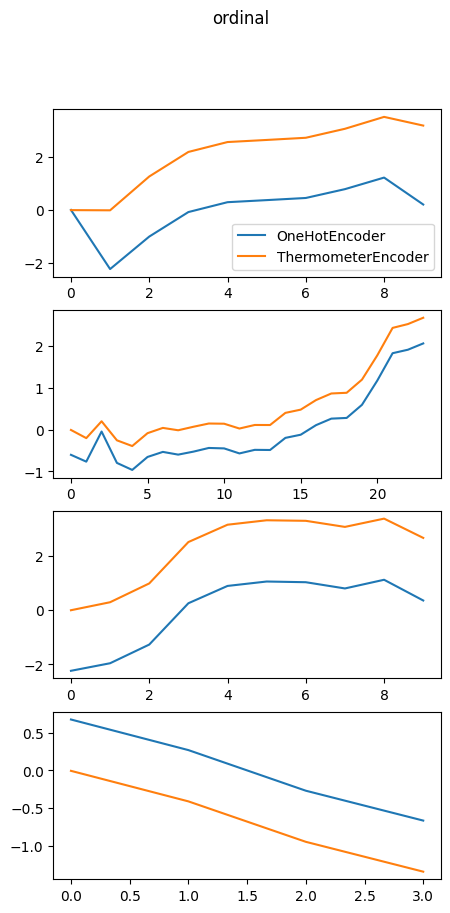

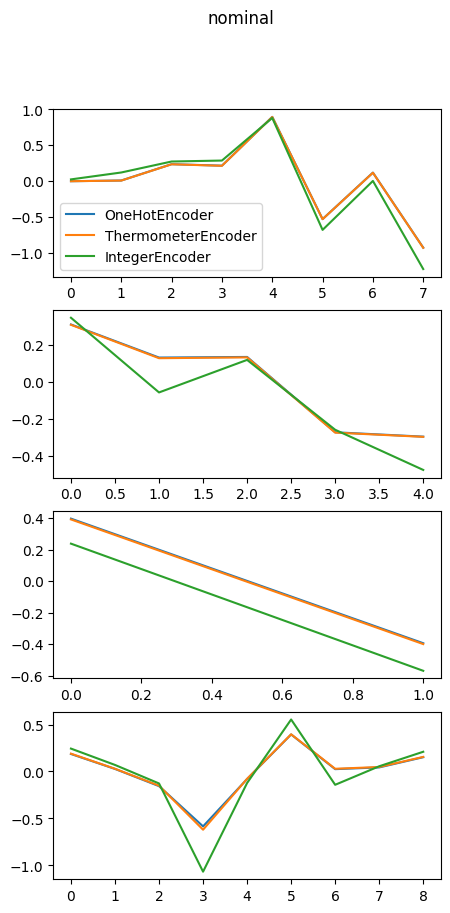

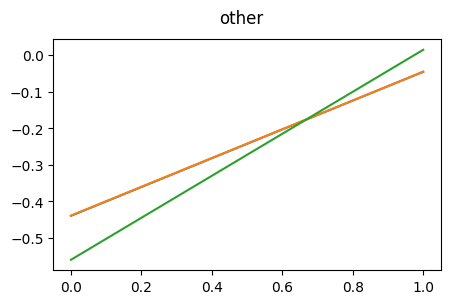

In [18]:
ohe_1 = models['OneHotEncoder'][0]
te_1 = models['ThermometerEncoder'][0]
ie_1 = models['IntegerEncoder'][0]



ordinal_dic_intv = ordinal_dic.copy()
for key, val in step_sizes.items():
    ordinal_dic_intv[key] = np.arange(*val)
    
    
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic.values()])
nom_coef_dic = utility.create_coef_dic(other_num, nominal_dic, nominal_features, ohe_1.coef_,te_1.coef_, ie_1.coef_)
ord_coef_dic = utility.create_coef_dic(other_num+nom_num, ordinal_dic_intv, ordinal_features, ohe_1.coef_,te_1.coef_)
ord_coef_dic_cum = {key: [val[0]]+[np.cumsum(val[1])] for key, val in ord_coef_dic.items()}

import matplotlib.pyplot as plt

label=['OneHotEncoder', 'ThermometerEncoder', 'IntegerEncoder']

fig, ax = plt.subplots(len(ord_coef_dic.keys()), 1, figsize=(5,10))
fig.suptitle('ordinal')
for i, (key, val) in enumerate(ord_coef_dic_cum.items()):
    for j in range(len(val)):
        ax[i].plot(range(len(val[j])), val[j], label = label[j])
ax[0].legend()    

fig, ax = plt.subplots(len(nom_coef_dic.keys()), 1, figsize=(5,10))
fig.suptitle('nominal')
for i, (key, val) in enumerate(nom_coef_dic.items()):
    for j in range(len(val)):
        ax[i].plot(range(len(val[j])), val[j], label = label[j])
ax[0].legend()  

fig = plt.figure(figsize=(5,3))
fig.suptitle('other')
plt.plot(range(len(ohe_1.coef_[0][:other_num])), ohe_1.coef_[0][:other_num])
plt.plot(range(len(te_1.coef_[0][:other_num])), te_1.coef_[0][:other_num])
plt.plot(range(len(ie_1.coef_[0][:other_num])), ie_1.coef_[0][:other_num])

In [19]:
k=10
ordinal_dic_intv = ordinal_dic.copy()
for key, val in step_sizes.items():
    ordinal_dic_intv[key] = np.arange(*val)
    
spec_dic = {key: [] for key in ordinal_dic_intv.keys()}
for i in range(k):
    ohe_1 = models['OneHotEncoder'][i]
    te_1 = models['ThermometerEncoder'][i]
    ie_1 = models['IntegerEncoder'][i]

    other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic_intv.values()])
    
    ord_coef_dic = utility.create_coef_dic(other_num+nom_num, ordinal_dic_intv, ordinal_features, ohe_1.coef_,te_1.coef_)
    ord_coef_dic_cum = {key: [val[0]]+[np.cumsum(val[1])] for key, val in ord_coef_dic.items()}
    for key, val in ord_coef_dic_cum.items():
        spec_dic[key] += [np.corrcoef(val)[0][1]]
spec_dic_mean_std = {key : (np.mean(val), np.std(val)) for key, val in spec_dic.items()}

In [20]:
spec_dic_mean_std

{'ENG': (0.9999998226076233, 5.901119050103339e-08),
 'WKHP': (0.9999415444569045, 1.7132663469020793e-05),
 'SCHL': (0.9977380370128278, 0.0005646083713502684),
 'AGEP': (0.8102733151614114, 0.01302333204992442)}

Text(0, 0.5, 'correlation')

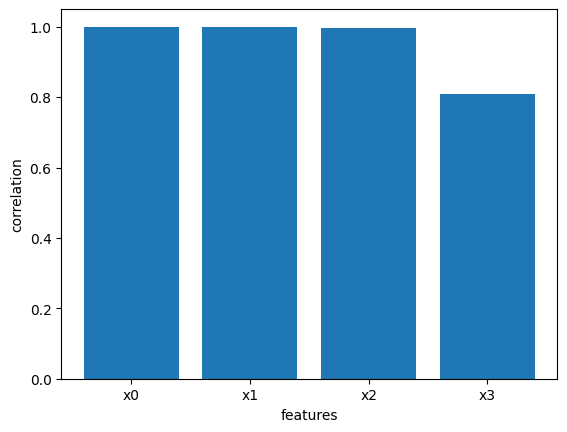

In [21]:
spec_plot = {key: val[0] for key, val in spec_dic_mean_std.items()}
plt.bar([f'x{i}' for i in range(len(spec_plot))], spec_plot.values())
plt.xlabel('features')
plt.ylabel('correlation')

In [21]:
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic.values()])

all_ohe_coef = np.array([models['OneHotEncoder'][i].coef_ for i in range(k)]).squeeze()
all_te_coef = np.array([models['ThermometerEncoder'][i].coef_ for i in range(k)]).squeeze()
# all_te_coef_cumsum = [np.cumsum(all_te_coef[:, other_num+nom_num:], axis=1) for i in [len(val) for val in ordinal_dic.values()]]
all_te_coef_cumsum = []
s=0
for i in [len(val) for val in ordinal_dic_intv.values()]:
    all_te_coef_cumsum.append(np.cumsum(all_te_coef[:, other_num+nom_num+s:other_num+nom_num+s+i], axis=1))
    s+=i
all_te_coef_cumsum = np.concatenate(tuple(all_te_coef_cumsum), axis=1)
all_ie_coef = np.array([models['IntegerEncoder'][i].coef_ for i in range(k)]).squeeze()


all_ohe_coef_mean = np.mean(all_ohe_coef, axis=0)
# all_te_coef_mean = np.array(list(np.mean(all_te_coef, axis=0)[:other_num+nom_num]) + list(np.mean(all_te_coef_cumsum, axis=0)))
all_te_coef_mean = np.mean(np.concatenate((all_te_coef[:, :other_num+nom_num], all_te_coef_cumsum), axis=1), axis=0)
all_ie_coef_mean = np.mean(all_ie_coef, axis=0)
all_ie_coef_temp = []
for idx, i in enumerate([len(val) for val in ordinal_dic_intv.values()]):
    all_ie_coef_temp.append(np.array([all_ie_coef_mean[other_num+nom_num:][idx]]*i)*np.linspace(1,i,i))
all_ie_coef_temp = np.concatenate(tuple(all_ie_coef_temp))
all_ie_coef_mean = np.concatenate((all_ie_coef_mean[:other_num+nom_num], all_ie_coef_temp))

# all_ohe_coef_mean = StandardScaler().fit_transform(all_ohe_coef_mean.reshape(-1, 1)).squeeze()
# all_te_coef_mean = StandardScaler().fit_transform(all_te_coef_mean.reshape(-1, 1)).squeeze()
# all_ie_coef_mean = StandardScaler().fit_transform(all_ie_coef_mean.reshape(-1, 1)).squeeze()

all_ohe_coef_std = np.std(all_ohe_coef, axis=0)
all_te_coef_std = np.array(list(np.std(all_te_coef, axis=0)[:other_num+nom_num]) + list(np.std(all_te_coef_cumsum, axis=0)))
all_ie_coef_std = np.std(all_ie_coef, axis=0)
all_ie_coef_temp = []
for idx, i in enumerate([len(val) for val in ordinal_dic_intv.values()]):
    all_ie_coef_temp.append(np.array([all_ie_coef_std[other_num+nom_num:][idx]]*i)*np.array([1]*i))
all_ie_coef_temp = np.concatenate(tuple(all_ie_coef_temp))
all_ie_coef_std = np.concatenate((all_ie_coef_std[:other_num+nom_num], all_ie_coef_temp))

# all_ohe_coef.shape, all_te_coef.shape, all_ie_coef.shape
all_ohe_coef_mean.shape, all_te_coef_mean.shape, all_ie_coef_mean.shape
# all_ohe_coef_std.shape, all_te_coef_std.shape, all_ie_coef_std.shape

((74,), (74,), (74,))

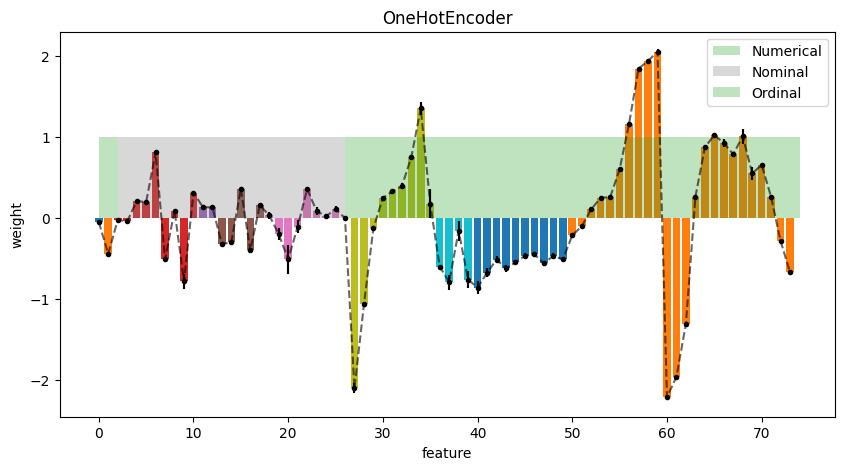

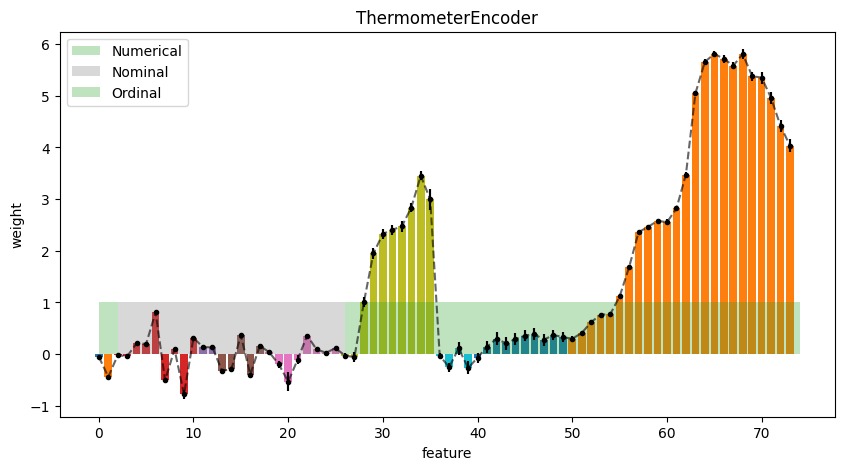

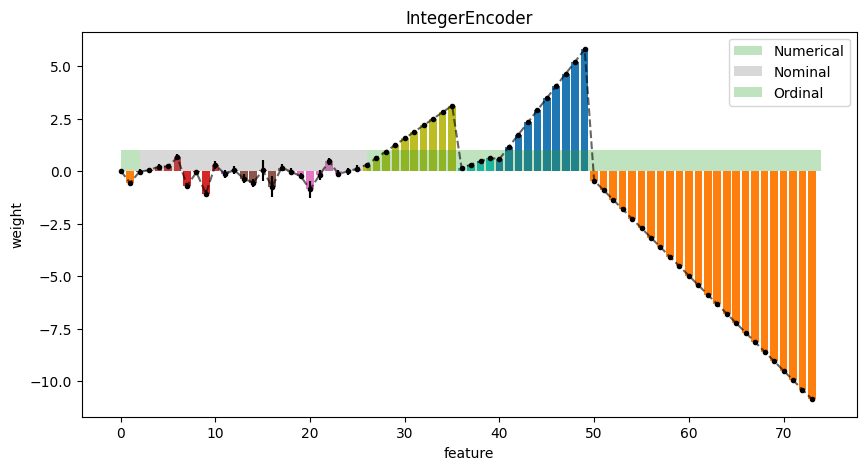

In [22]:
import matplotlib.pyplot as plt
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic_intv.values()])
title = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
label = ['Numerical', 'Nominal', 'Ordinal']
for idx, (all_mean, all_std) in enumerate(zip([all_ohe_coef_mean, all_te_coef_mean, all_ie_coef_mean], [all_ohe_coef_std, all_te_coef_std, all_ie_coef_std])):
    plt.figure(figsize=(10,5))
    start_1 = 0
    # if idx == 2:
    #     ord_num = len(ordinal_dic.values())
    for idxx, (i, unique_val) in enumerate(zip([other_num, nom_num, ord_num], [[1]*other_num, [len(val) for val in nominal_dic.values()], [len(val) for val in ordinal_dic_intv.values()]])):
        start_2 = 0
        # if idxx == 2 and idx == 2:
        #     unique_val = [1]*i
        for j in unique_val:  
            plt.bar(range(len(all_mean))[start_1+start_2:start_1+start_2+i+j], all_mean[start_1+start_2:start_1+start_2+i+j])
            start_2 += j
        plt.fill_between(x=[start_1, start_1+i] ,y1=[0.0], y2=[1,1],alpha=0.3,label=label[idxx])
        start_1 += i
        
    plt.errorbar(range(len(all_mean)), all_mean, all_std, color='black', fmt='.')
    plt.errorbar(range(len(all_mean)), all_mean, all_std, color='black', fmt='--', alpha=0.6)
    plt.title(title[idx])
    plt.ylabel('weight'), plt.xlabel('feature')
    plt.legend()


In [23]:
import math
def deep_copy(dic):
    dic_res = {}
    for key, val in dic.items():
        dic_res[key] = deep_copy(val) if isinstance(val, dict) else val
    return dic_res
def round_decimal_places(df, d):
    dec = math.pow(10,d)
    df_copy = df.copy()
    df_copy = df_copy.map(lambda x: (math.ceil(x[0]*dec)/dec, math.ceil(x[1]*dec)/dec))
    return df_copy
res_temp = res_train
res_copy = deep_copy(res_temp)
d = 12
for encoder in res.keys():
    res_copy[encoder]['clf_rep']['accuracy'] = {key: res_temp[encoder]['clf_rep']['accuracy'] for key in res_copy[encoder]['clf_rep']['macro avg'].keys()}
# df_lists = [pd.DataFrame(res_copy[key.__str__()]['clf_rep']).rename_axis(key.__str__(), axis="columns") for key in res_copy.keys()]
df_lists = [round_decimal_places(pd.DataFrame(res_copy[key.__str__()]['clf_rep']).rename_axis(key.__str__(), axis="columns").drop(index='support'), d) for key in res_copy.keys()]

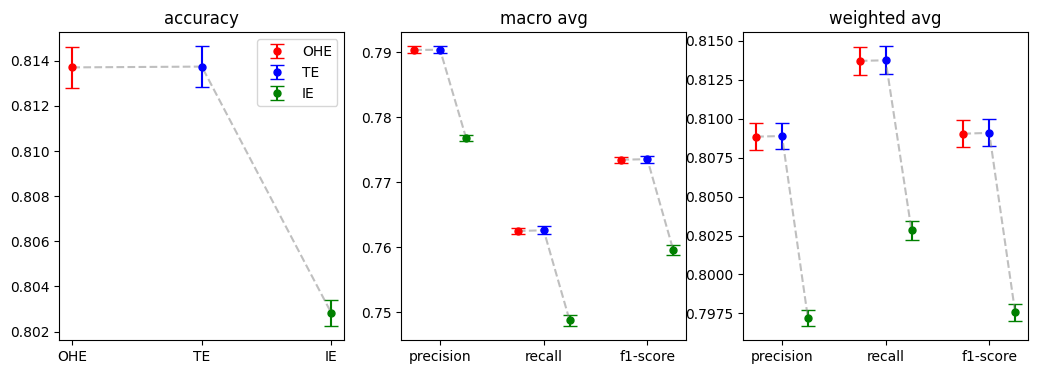

In [24]:
import matplotlib.pyplot as plt

plot_dic = {}
metrics = ['accuracy','macro avg', 'weighted avg']
inner_metrics = ['precision', 'recall', 'f1-score']

plot_dic = {}
for key in metrics:
    plot_dic[key] = {k: [] for k in inner_metrics}
    for key2 in inner_metrics:
        for dfs in df_lists:
            df_dict = dfs.to_dict()
            plot_dic[key][key2].append(list(df_dict[key][key2]))
            
            
models = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
model_names = ['OHE', 'TE', 'IE']
colors = ['r', 'b', 'g']
x_axis_placement = np.array([-0.25, 0, 0.25])
fig, ax = plt.subplots(1, 3, figsize=(12.5,4))
ax = ax.ravel()
for i, (key, val) in enumerate(plot_dic.items()):
    if key == 'accuracy':
        accs = np.array(val['precision'])
        ax[i].errorbar(range(len(accs)), accs[:,0], accs[:,1], alpha = 0.5, fmt='--', color = 'grey') 
        for j, (mean, std) in enumerate(accs):
            (_,caps,_)= ax[i].errorbar(j, accs[:,0][j], accs[:,1][j], label=model_names[j],color = colors[j], alpha = 1, fmt='.', markersize=10, capsize = 5) 
            for cap in caps:
                cap.set_markeredgewidth(1)
    else:  
        for j, (key2, val2) in enumerate(val.items()):
            model = np.array(val2)    
            x_axis=np.ones(len(model))*j
            ax[i].errorbar(x_axis + x_axis_placement, model[:,0], model[:,1], alpha = 0.5, fmt='--', color = 'grey')
            for k in range(len(x_axis)):
                (_,caps,_)= ax[i].errorbar(j + x_axis_placement[k], model[:,0][k], model[:,1][k], label=model_names[k], color = colors[k], alpha = 1, fmt='.', markersize=10, capsize = 5) if j == 0 else ax[i].errorbar(j + x_axis_placement[k], model[:,0][k], model[:,1][k], color = colors[k], alpha = 1, fmt='.', markersize=10, capsize = 5) 
                for cap in caps:
                    cap.set_markeredgewidth(1)
for i, axe in enumerate(ax):
    axe.set_title(metrics[i])
    if metrics[i] == 'accuracy':
        axe.set_xticks(range(len(models)), model_names)
    else:
        axe.set_xticks(range(len(inner_metrics)), inner_metrics)

ax[0].legend()             
                

In [58]:
with open('acs_datasource_clf_result/acs_datasource_clf.csv','w') as f:
    for df in df_lists:
        f.write(f"{df.columns.name}\n")
        df.to_csv(f)
        f.write("\n")

In [17]:
res_train

{'OneHotEncoder': {'clf_rep': {'1.0': {'precision': (0.8400225515211008,
     0.0009777201642349415),
    'recall': (0.8999284890814636, 0.0011302836088846544),
    'f1-score': (0.8689441997652863, 0.001029987395359919),
    'support': (51010.2, 151.15144723091473)},
   '2.0': {'precision': (0.7406275559774953, 0.0005365908126167551),
    'recall': (0.6250758297620369, 0.0017491941758844428),
    'f1-score': (0.6779622679057475, 0.0011670559445450324),
    'support': (23318.1, 151.05128268240557)},
   'accuracy': (0.8137075626205291, 0.0009198885288849253),
   'macro avg': {'precision': (0.7903250537492981, 0.0005523986611208866),
    'recall': (0.7625021594217503, 0.0005311654819286398),
    'f1-score': (0.7734532338355169, 0.0004728489291086314),
    'support': (74328.3, 0.45825756949558405)},
   'weighted avg': {'precision': (0.8088427394145492, 0.0008608170659020051),
    'recall': (0.8137075626205291, 0.0009198885288849253),
    'f1-score': (0.8090336963919622, 0.00086861027235777

In [18]:
res

{'OneHotEncoder': {'clf_rep': {'1.0': {'precision': (0.8397496974754685,
     0.013266472973557555),
    'recall': (0.899566080158863, 0.005247696195975325),
    'f1-score': (0.8685792353144306, 0.008044743245566229),
    'support': (5667.8, 151.15144723091473)},
   '2.0': {'precision': (0.7396148094232698, 0.015453677164688399),
    'recall': (0.6251828157354289, 0.009426217479844602),
    'f1-score': (0.6774356037800996, 0.006201011961550739),
    'support': (2590.9, 151.05128268240557)},
   'accuracy': (0.8134207555224036, 0.008403077319857592),
   'macro avg': {'precision': (0.7896822534493693, 0.004803886825393427),
    'recall': (0.7623744479471458, 0.005120348827751731),
    'f1-score': (0.7730074195472652, 0.004735278003292422),
    'support': (8258.7, 0.45825756949558394)},
   'weighted avg': {'precision': (0.8088058354636555, 0.008533704428028437),
    'recall': (0.8134207555224036, 0.008403077319857592),
    'f1-score': (0.8087984676841886, 0.0090382675983874),
    'support'